In [1]:
# train a quantum-classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from qibo import gates, hamiltonians, models
from matplotlib import pyplot
from scipy.optimize import minimize

In [2]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=n_inputs))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def rotate(theta, x, layers=4, nqubits=1):
    new_theta = []
    index = 0
    for l in range(layers):
        for q in range(nqubits):
           new_theta.append(theta[index]*x + theta[index+1])
           index += 2
        for q in range(nqubits):
           new_theta.append(theta[index]*x + theta[index+1])
           index += 2
    return new_theta
 
# define the combined generator and discriminator model, for updating the generator
def define_cost_gan(params, discriminator, latent_dim, samples):
    # generate fake samples
    x_fake, y_fake = generate_fake_samples(params, latent_dim, samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    return acc_fake
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.25, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y

# define hamiltonian to generate fake samples
def hamiltonian(nqubits=1):
    m0 = (1/nqubits)*hamiltonians.Z(nqubits, numpy=True).matrix
    ham = hamiltonians.Hamiltonian(nqubits, m0)
    return ham
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(params, latent_dim, samples, nqubits=1, layers=4):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # quantum generator circuit
    circuit = models.Circuit(nqubits)
    for l in range(layers):
        for q in range(nqubits):
            circuit.add(gates.RY(q, theta=0))
        for q in range(nqubits):
            circuit.add(gates.RZ(q, theta=0))    
    # generator outputs
    X = []
    for i in range(samples):
        newparams = rotate(params, x_input[i][0])
        circuit.set_parameters(newparams)
        X.append(hamiltonian().expectation(circuit.execute()).numpy().real)
    # shape array
    X = np.array(X).reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake distributions
def summarize_performance(epoch, params, discriminator, latent_dim, samples, nbins):
    # prepare real samples
    x_real, y_real = generate_real_samples(samples)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(params, latent_dim, samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()
 
# train the generator and discriminator
def train(d_model, latent_dim, n_epochs=50000, samples=1000, nbins=20, n_eval=1):
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    initial_params = np.random.uniform(0, 2*np.pi, 16)
    # prepare real samples
    x_real, y_real = generate_real_samples(half_samples)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(initial_params, latent_dim, half_samples)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # update generator
    train_generator = minimize(lambda p: define_cost_gan(p, d_model, latent_dim, samples), initial_params,
                          method='Nelder-Mead', options={'maxiter': 48, 'maxfev': 48})
    summarize_performance(1, train_generator.x, d_model, latent_dim, samples, nbins)    
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(train_generator.x, latent_dim, half_samples)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # update generator
        train_generator = minimize(lambda p: define_cost_gan(p, d_model, latent_dim, samples), train_generator.x,
                          method='Nelder-Mead', options={'maxiter': 48, 'maxfev': 48}) 
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i+2, train_generator.x, d_model, latent_dim, samples, nbins)

epoch:  1 acc_real:  0.061000000685453415 acc_fake:  0.9359999895095825


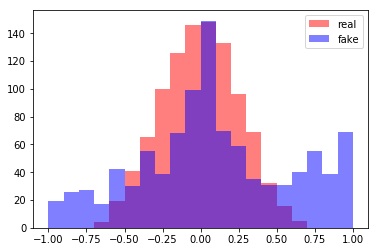

epoch:  2 acc_real:  0.07999999821186066 acc_fake:  0.890999972820282


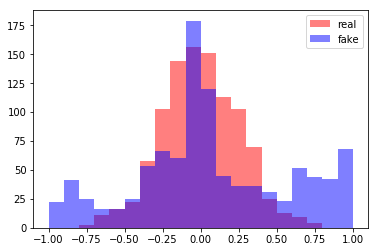

epoch:  3 acc_real:  0.10999999940395355 acc_fake:  0.8569999933242798


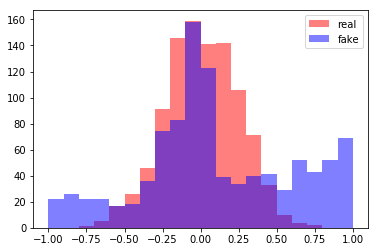

epoch:  4 acc_real:  0.12300000339746475 acc_fake:  0.8349999785423279


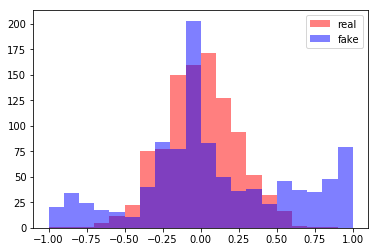

epoch:  5 acc_real:  0.13500000536441803 acc_fake:  0.796999990940094


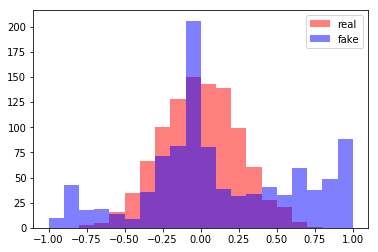

epoch:  6 acc_real:  0.1340000033378601 acc_fake:  0.7990000247955322


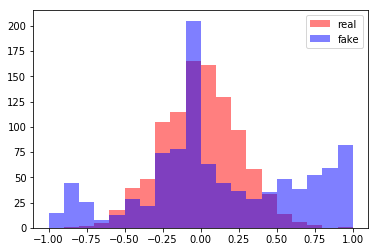

epoch:  7 acc_real:  0.12700000405311584 acc_fake:  0.8090000152587891


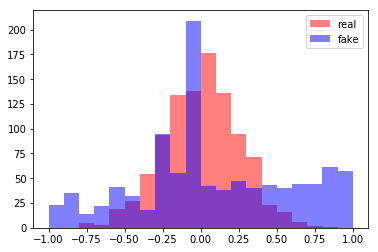

epoch:  8 acc_real:  0.1550000011920929 acc_fake:  0.7929999828338623


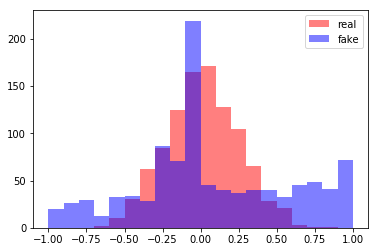

epoch:  9 acc_real:  0.13300000131130219 acc_fake:  0.781000018119812


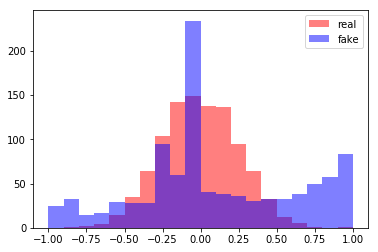

epoch:  10 acc_real:  0.13300000131130219 acc_fake:  0.8130000233650208


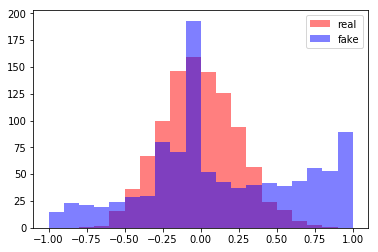

epoch:  11 acc_real:  0.13199999928474426 acc_fake:  0.7900000214576721


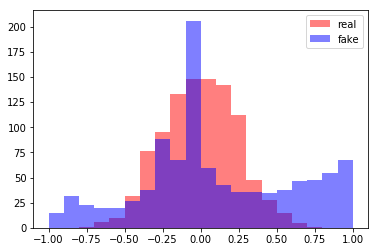

epoch:  12 acc_real:  0.1340000033378601 acc_fake:  0.7889999747276306


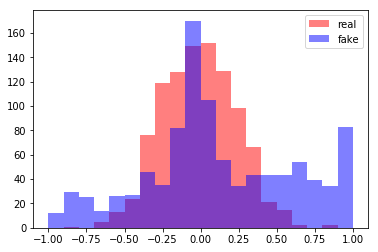

epoch:  13 acc_real:  0.1509999930858612 acc_fake:  0.800000011920929


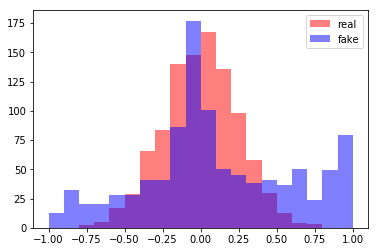

epoch:  14 acc_real:  0.15399999916553497 acc_fake:  0.7889999747276306


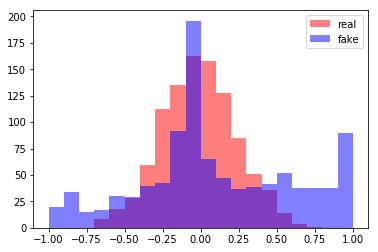

epoch:  15 acc_real:  0.14300000667572021 acc_fake:  0.796999990940094


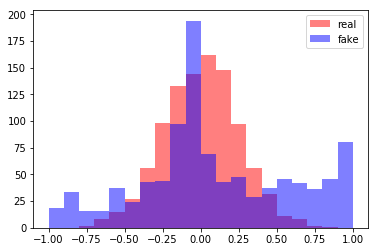

epoch:  16 acc_real:  0.1379999965429306 acc_fake:  0.7919999957084656


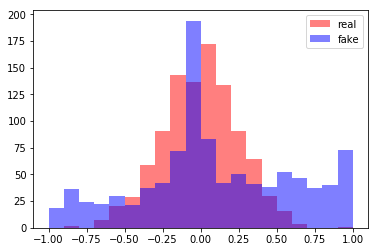

epoch:  17 acc_real:  0.12700000405311584 acc_fake:  0.8009999990463257


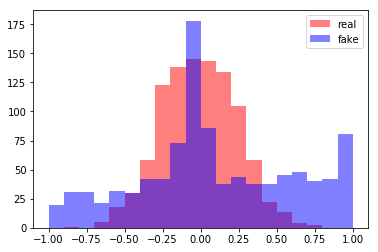

epoch:  18 acc_real:  0.15600000321865082 acc_fake:  0.8159999847412109


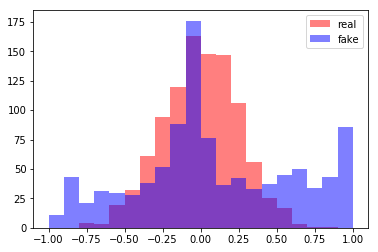

epoch:  19 acc_real:  0.15199999511241913 acc_fake:  0.7919999957084656


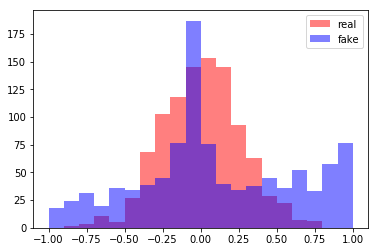

epoch:  20 acc_real:  0.1589999943971634 acc_fake:  0.7879999876022339


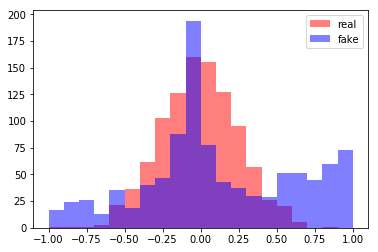

epoch:  21 acc_real:  0.14499999582767487 acc_fake:  0.8029999732971191


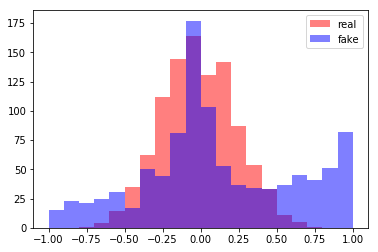

epoch:  22 acc_real:  0.17499999701976776 acc_fake:  0.8100000023841858


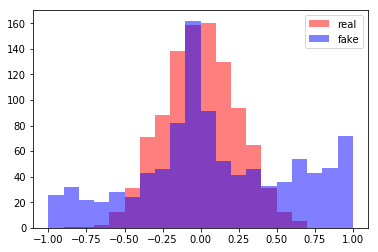

epoch:  23 acc_real:  0.1599999964237213 acc_fake:  0.7900000214576721


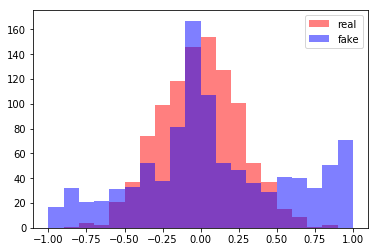

epoch:  24 acc_real:  0.164000004529953 acc_fake:  0.7960000038146973


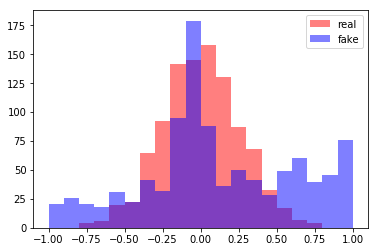

epoch:  25 acc_real:  0.1720000058412552 acc_fake:  0.7940000295639038


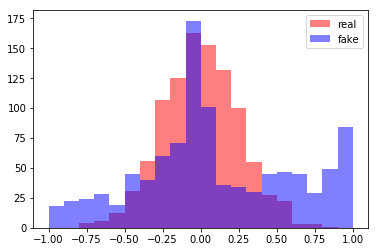

epoch:  26 acc_real:  0.16599999368190765 acc_fake:  0.7850000262260437


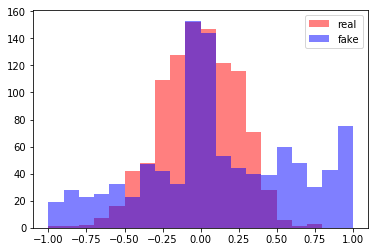

epoch:  27 acc_real:  0.18700000643730164 acc_fake:  0.7620000243186951


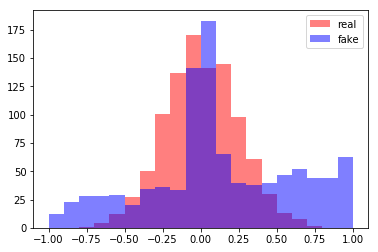

epoch:  28 acc_real:  0.17599999904632568 acc_fake:  0.7609999775886536


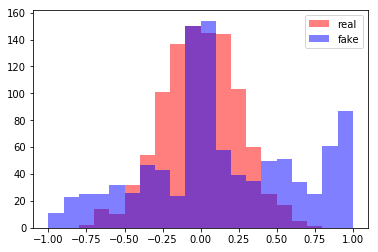

epoch:  29 acc_real:  0.1770000010728836 acc_fake:  0.7580000162124634


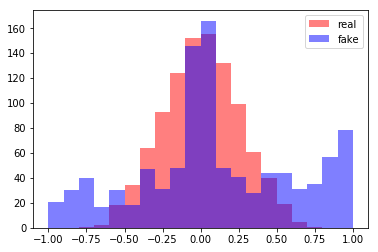

epoch:  30 acc_real:  0.20800000429153442 acc_fake:  0.7699999809265137


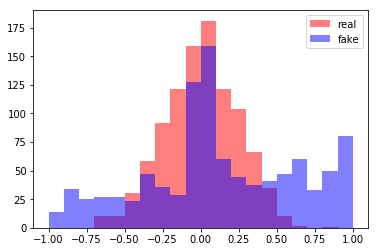

epoch:  31 acc_real:  0.20200000703334808 acc_fake:  0.7570000290870667


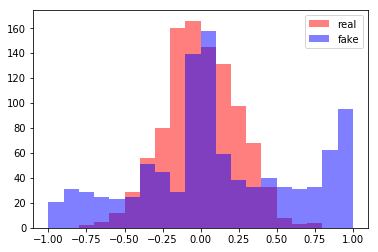

epoch:  32 acc_real:  0.20200000703334808 acc_fake:  0.7480000257492065


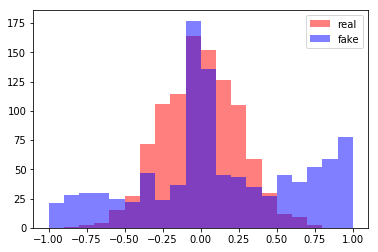

epoch:  33 acc_real:  0.18700000643730164 acc_fake:  0.7459999918937683


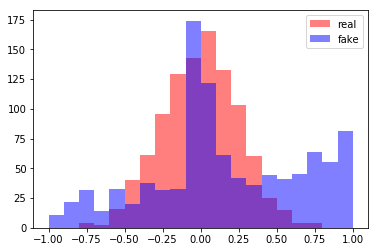

epoch:  34 acc_real:  0.21299999952316284 acc_fake:  0.7360000014305115


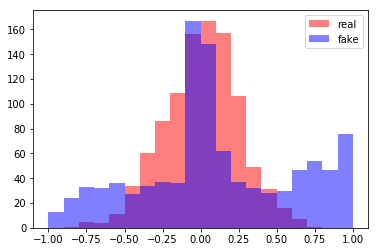

epoch:  35 acc_real:  0.20000000298023224 acc_fake:  0.7419999837875366


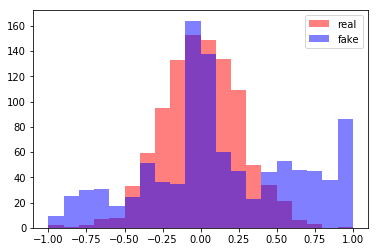

epoch:  36 acc_real:  0.19599999487400055 acc_fake:  0.7390000224113464


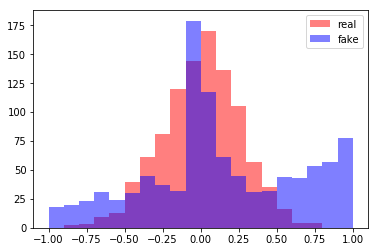

epoch:  37 acc_real:  0.21400000154972076 acc_fake:  0.7519999742507935


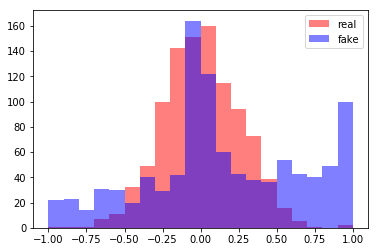

epoch:  38 acc_real:  0.21199999749660492 acc_fake:  0.7120000123977661


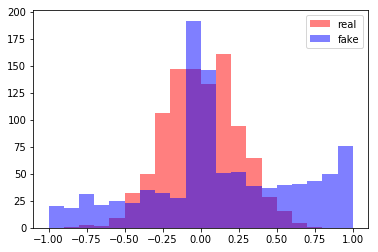

epoch:  39 acc_real:  0.2280000001192093 acc_fake:  0.7450000047683716


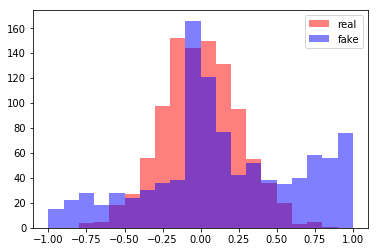

epoch:  40 acc_real:  0.24899999797344208 acc_fake:  0.7269999980926514


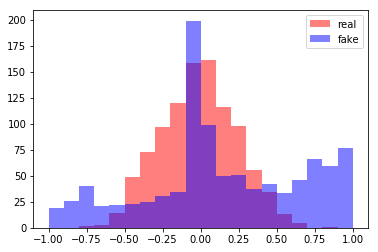

epoch:  41 acc_real:  0.22499999403953552 acc_fake:  0.6890000104904175


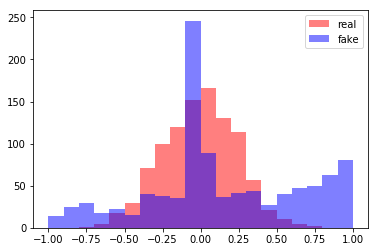

epoch:  42 acc_real:  0.25099998712539673 acc_fake:  0.6850000023841858


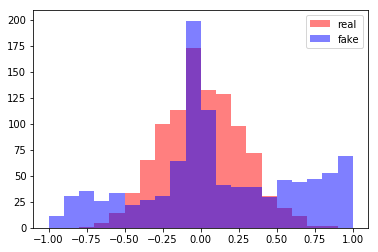

epoch:  43 acc_real:  0.2529999911785126 acc_fake:  0.7260000109672546


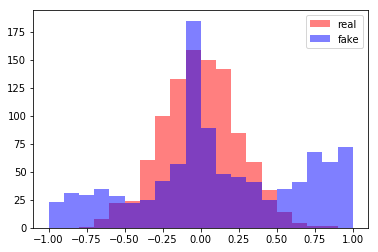

epoch:  44 acc_real:  0.25600001215934753 acc_fake:  0.7110000252723694


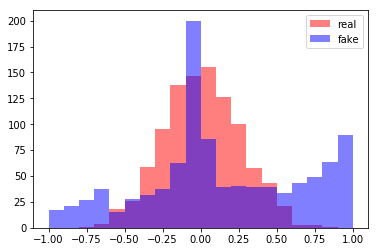

epoch:  45 acc_real:  0.27300000190734863 acc_fake:  0.7250000238418579


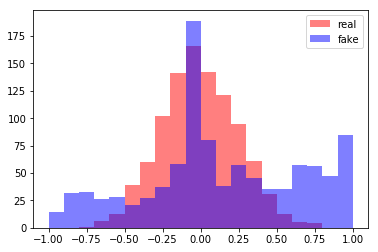

epoch:  46 acc_real:  0.2619999945163727 acc_fake:  0.7009999752044678


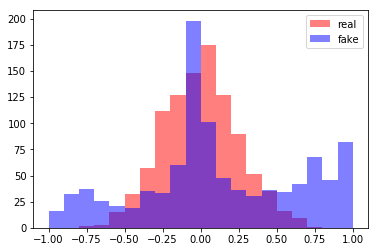

epoch:  47 acc_real:  0.27300000190734863 acc_fake:  0.703000009059906


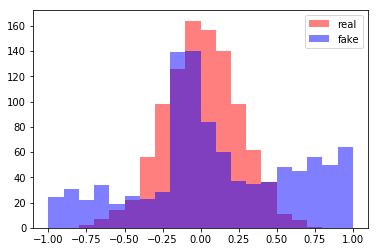

epoch:  48 acc_real:  0.2919999957084656 acc_fake:  0.7039999961853027


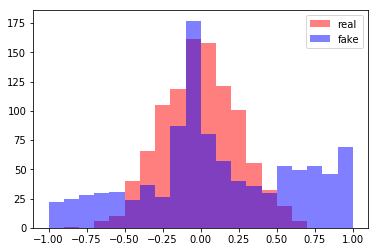

epoch:  49 acc_real:  0.2879999876022339 acc_fake:  0.6980000138282776


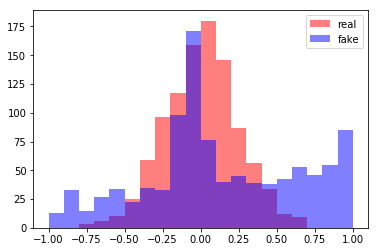

epoch:  50 acc_real:  0.3070000112056732 acc_fake:  0.6869999766349792


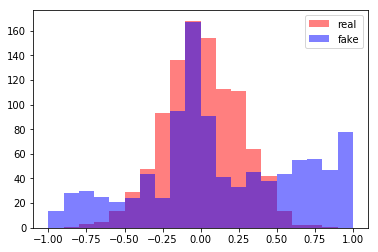

epoch:  51 acc_real:  0.3140000104904175 acc_fake:  0.6980000138282776


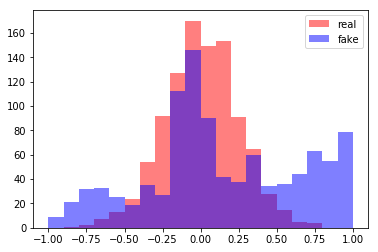

epoch:  52 acc_real:  0.29899999499320984 acc_fake:  0.6800000071525574


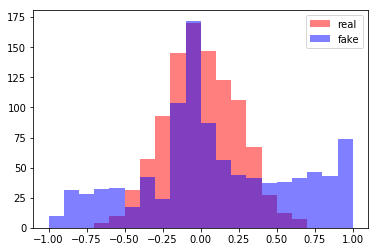

epoch:  53 acc_real:  0.2919999957084656 acc_fake:  0.6880000233650208


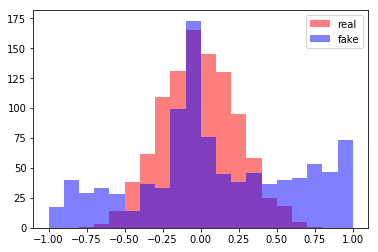

epoch:  54 acc_real:  0.29600000381469727 acc_fake:  0.7279999852180481


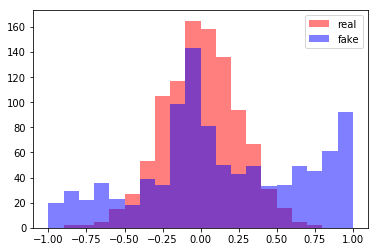

epoch:  55 acc_real:  0.31200000643730164 acc_fake:  0.699999988079071


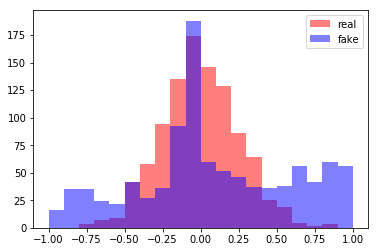

epoch:  56 acc_real:  0.28600001335144043 acc_fake:  0.6940000057220459


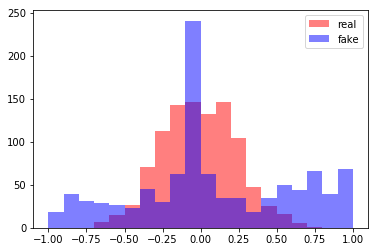

epoch:  57 acc_real:  0.31200000643730164 acc_fake:  0.675000011920929


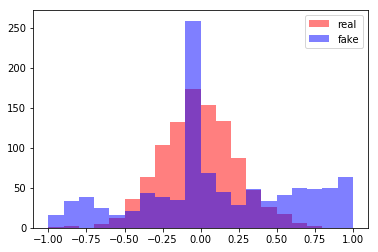

epoch:  58 acc_real:  0.2980000078678131 acc_fake:  0.7059999704360962


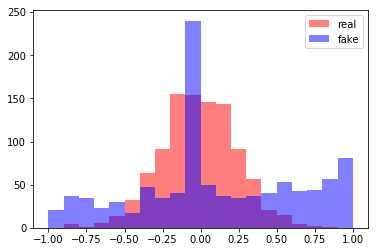

epoch:  59 acc_real:  0.29899999499320984 acc_fake:  0.6940000057220459


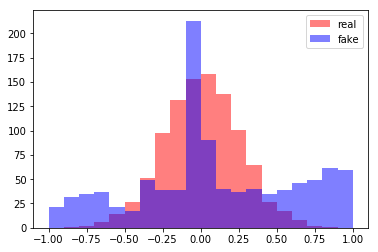

epoch:  60 acc_real:  0.32100000977516174 acc_fake:  0.6850000023841858


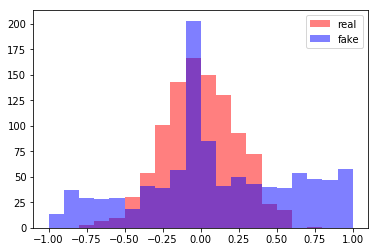

epoch:  61 acc_real:  0.3190000057220459 acc_fake:  0.6809999942779541


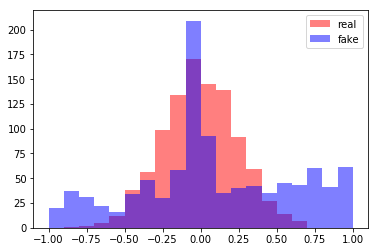

epoch:  62 acc_real:  0.3059999942779541 acc_fake:  0.6700000166893005


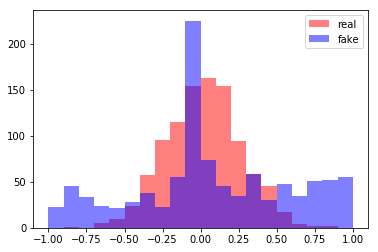

epoch:  63 acc_real:  0.31299999356269836 acc_fake:  0.6930000185966492


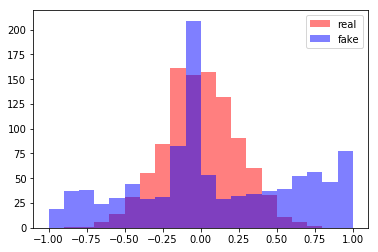

epoch:  64 acc_real:  0.3089999854564667 acc_fake:  0.7200000286102295


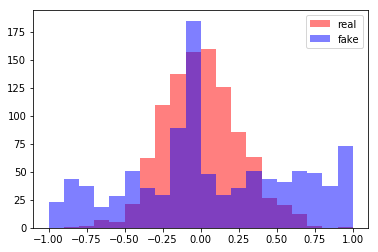

epoch:  65 acc_real:  0.3050000071525574 acc_fake:  0.7039999961853027


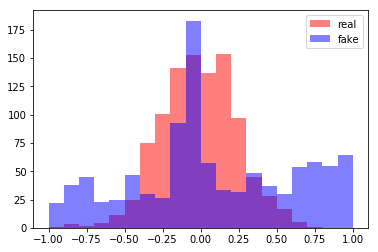

epoch:  66 acc_real:  0.3059999942779541 acc_fake:  0.7120000123977661


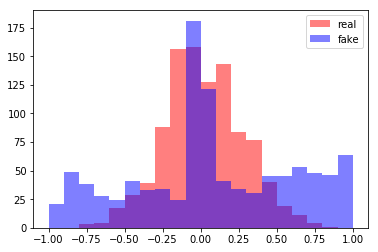

epoch:  67 acc_real:  0.29600000381469727 acc_fake:  0.7089999914169312


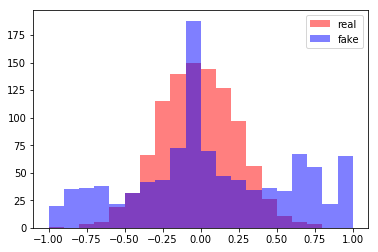

epoch:  68 acc_real:  0.28700000047683716 acc_fake:  0.7110000252723694


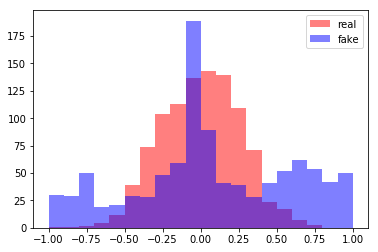

In [ ]:
# size of the latent space
latent_dim = 1
# create the discriminator
discriminator = define_discriminator()
# train model
train(discriminator, latent_dim)